In [6]:
import xarray as xr
import semopy as sm
from pcv.process import select_data
import matplotlib.pylab as plt
import pandas as pd
import numpy as np

In [7]:
temp_path = "/Users/anand/Documents/data/project_3_data/data/aggregated_temp.nc"
tp_path = "/Users/anand/Documents/data/project_3_data/data/aggregated_tp.nc"
rad_path = "/Users/anand/Documents/data/project_3_data/data/aggregated_ssrd.nc"
lai_path = "/Users/anand/Documents/data/project_3_data/data/aggregated_lai.nc"
swvlall_path = "/Users/anand/Documents/data/project_3_data/data/aggregated_swvlall.nc"
vpd_path = "/Users/anand/Documents/data/project_3_data/data/aggregated_vpd.nc"


temp_data = xr.open_dataset(temp_path)
tp_data = xr.open_dataset(tp_path)
ssrd_data = xr.open_dataset(rad_path)
swvlall_data = xr.open_dataset(swvlall_path)
vpd_data = xr.open_dataset(vpd_path)
lai_data = xr.open_dataset(lai_path)

In [8]:
temp_winter = select_data(temp_data,  "winter")
temp_spring = select_data(temp_data,  "spring")
temp_summer = select_data(temp_data,  "summer")

tp_winter = select_data(tp_data,  "winter")
tp_spring = select_data(tp_data,  "spring")
tp_summer = select_data(tp_data,  "summer")

ssrd_winter = select_data(ssrd_data,  "winter")
ssrd_spring = select_data(ssrd_data,  "spring")
ssrd_summer = select_data(ssrd_data,  "summer")

lai_winter = select_data(lai_data,  "winter")
lai_spring = select_data(lai_data,  "spring")
lai_summer = select_data(lai_data,  "summer")

swvlall_winter = select_data(swvlall_data,  "winter")
swvlall_spring = select_data(swvlall_data,  "spring")
swvlall_summer = select_data(swvlall_data,  "summer")

vpd_winter = select_data(vpd_data,  "winter")
vpd_spring = select_data(vpd_data,  "spring")
vpd_summer = select_data(vpd_data,  "summer")

In [20]:
model_data = xr.Dataset(
    {
        "chi2": (
            ("latitude", "longitude"), np.full((200, 220), np.nan)),         
        "lai_summer_to_lai_spring_E": (
            ("latitude", "longitude"), np.full((200, 220), np.nan)),
        "swvlall_summer_to_lai_spring_E": (
            ("latitude", "longitude"), np.full((200, 220), np.nan)),
        
    },
    coords= {"latitude":lai_data.latitude, "longitude":lai_data.longitude}
)



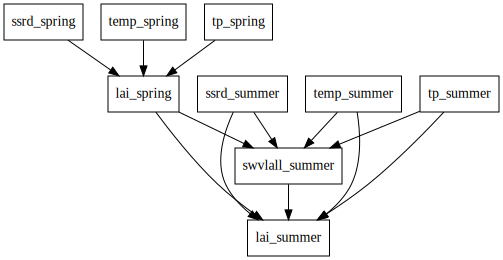

In [21]:
mod = """
# measurement model

lai_spring ~ tp_spring + ssrd_spring + temp_spring
#lai_summer ~ lai_spring
lai_summer ~ ssrd_summer + temp_summer+ tp_summer
swvlall_summer ~ lai_spring + ssrd_summer + temp_summer+ tp_summer
lai_summer ~ swvlall_summer + ssrd_summer + temp_summer+ tp_summer
lai_summer ~ lai_spring

"""
model = sm.Model(mod)
sm.semplot(model, f"images/sem_fit_general.png")


In [27]:
for lat in range(200):
    print(lat)
    for lon in range(220):
        lai_w = lai_winter.__xarray_dataarray_variable__[:, lat, lon].to_numpy()[-39:]
        if np.isnan(lai_w).any() == True:
            pass
        else:

            lai_sp = lai_spring.__xarray_dataarray_variable__[:, lat, lon].to_numpy()[-39:]
            lai_su = lai_summer.__xarray_dataarray_variable__[:, lat, lon].to_numpy()[-39:]
            
            temp_w = temp_winter.__xarray_dataarray_variable__[:, lat, lon].to_numpy()[-39:]
            temp_sp = temp_spring.__xarray_dataarray_variable__[:, lat, lon].to_numpy()[-39:]
            temp_su = temp_summer.__xarray_dataarray_variable__[:, lat, lon].to_numpy()[-39:]

            tp_w = tp_winter.__xarray_dataarray_variable__[:, lat, lon].to_numpy()[-39:]
            tp_sp = tp_spring.__xarray_dataarray_variable__[:, lat, lon].to_numpy()[-39:]
            tp_su = tp_summer.__xarray_dataarray_variable__[:, lat, lon].to_numpy()[-39:]
            
            ssrd_w = ssrd_winter.__xarray_dataarray_variable__[:, lat, lon].to_numpy()[-39:]
            ssrd_sp = ssrd_spring.__xarray_dataarray_variable__[:, lat, lon].to_numpy()[-39:]
            ssrd_su = ssrd_summer.__xarray_dataarray_variable__[:, lat, lon].to_numpy()[-39:]

            vpd_w = vpd_winter.__xarray_dataarray_variable__[:, lat, lon].to_numpy()[-39:]
            vpd_sp = vpd_spring.__xarray_dataarray_variable__[:, lat, lon].to_numpy()[-39:]
            vpd_su = vpd_summer.__xarray_dataarray_variable__[:, lat, lon].to_numpy()[-39:]

            swvlall_w = swvlall_winter.__xarray_dataarray_variable__[:, lat, lon].to_numpy()[-39:]
            swvlall_sp = swvlall_spring.__xarray_dataarray_variable__[:, lat, lon].to_numpy()[-39:]
            swvlall_su = swvlall_summer.__xarray_dataarray_variable__[:, lat, lon].to_numpy()[-39:]
            assert temp_w.shape == temp_sp.shape == temp_su.shape
            
            list_val = [temp_w[:-1], temp_sp[1:], temp_su[1:],
                    tp_w[:-1], tp_sp[1:], tp_su[1:], 
                    ssrd_w[:-1], ssrd_sp[1:], ssrd_su[1:], 
                    lai_w[:-1], lai_sp[1:], lai_su[1:],
                    vpd_w[:-1], vpd_sp[1:], vpd_su[1:],
                    swvlall_w[:-1], swvlall_sp[1:], swvlall_su[1:]
                    ]

            col_names = ["temp_winter", "temp_spring", "temp_summer",
                            "tp_winter", "tp_spring", "tp_summer",
                            "ssrd_winter", "ssrd_spring", "ssrd_summer",
                            "lai_winter", "lai_spring", "lai_summer", 
                            "vpd_winter", "vpd_spring", "vpd_summer",
                            "swvlall_winter", "swvlall_spring", "swvlall_summer",
                            ]    
            data = np.vstack(list_val).T

            df = pd.DataFrame(data, columns=col_names)
            df=(df-df.mean())/df.std()
            
            model = sm.Model(mod)
            model.fit(df)
            chi2 = sm.calc_stats(model)["chi2 p-value"][0]
            model_data.chi2[lat, lon] = chi2
            model_data.lai_summer_to_lai_spring_E[lat, lon] = model.inspect().iloc[11, :].Estimate
            model_data.swvlall_summer_to_lai_spring_E[lat, lon] = model.inspect().iloc[3, :].Estimate

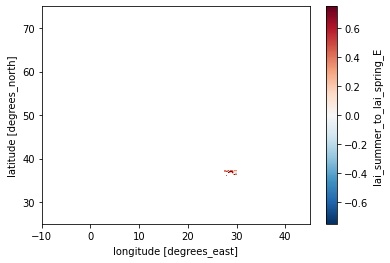

In [26]:
model_data.lai_summer_to_lai_spring_E.plot()

In [12]:
model.inspect().iloc[11,:]


,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,lai_spring,~,tp_spring,-0.030413,0.217409,-0.139887,0.888749
1,lai_spring,~,ssrd_spring,-0.236065,0.211382,-1.116767,0.264094
2,lai_spring,~,temp_spring,-0.138428,0.176117,-0.786000,0.431867
3,swvlall_summer,~,lai_spring,0.095462,0.156293,0.610787,0.541341
4,swvlall_summer,~,ssrd_summer,-0.193955,0.177510,-1.092641,0.274551
5,swvlall_summer,~,temp_summer,-0.133014,0.158386,-0.839807,0.401016
6,swvlall_summer,~,tp_summer,0.023091,0.177405,0.130162,0.896439
7,lai_summer,~,ssrd_summer,-0.175984,0.148175,-1.187674,0.234962
8,lai_summer,~,temp_summer,0.245255,0.131385,1.866687,0.061945
9,lai_summer,~,tp_summer,0.039847,0.145847,0.273210,0.784692


In [18]:
model.inspect().iloc[11,:].Estimate


0.46149856270942374

In [41]:
sm.calc_stats(model)["chi2 p-value"]

Value    0.098711
Name: chi2 p-value, dtype: float64

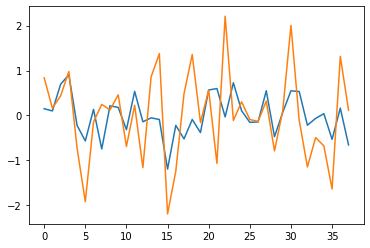

In [42]:
df_pred = df.copy()
df_pred["lai_summer"] = float('nan')

pred_lai_summer = model.predict(df_pred).lai_summer
plt.plot(pred_lai_summer.values)
plt.plot(df.lai_summer.values)

In [3]:
model.inspect()

NameError: name 'model' is not defined

AttributeError: 'Model' object has no attribute 'save'